In [140]:
# import the needed Python libraries

from pandas import Series, DataFrame
import pandas as pd
import numpy as np
import matplotlib.pylab as plt
from sklearn.cross_validation import train_test_split
from sklearn import preprocessing
from sklearn.cluster import KMeans

In [141]:
# Getting and cleaning data

AH_data = pd.read_csv(r'D://tree_addhealth.csv')

data_clean = AH_data.dropna()

In [142]:
#Creating a dataset cluster containing our clustering variables  

cluster=data_clean[['ALCEVR1','ALCPROBS1','ESTEEM1','EXPEL1','PARPRES','SCHCONN1','VIOL1','PARACTV']]
cluster.describe()

,ALCEVR1,ALCPROBS1,ESTEEM1,EXPEL1,PARPRES,SCHCONN1,VIOL1,PARACTV
count,4575.000000,4575.000000,4575.000000,4575.000000,4575.000000,4575.000000,4575.000000,4575.000000
mean,0.527432,0.369180,40.952131,0.040219,13.398033,28.360656,1.618579,6.290710
std,0.499302,0.894947,5.381439,0.196493,2.085837,5.156385,2.593230,3.360219
min,0.000000,0.000000,18.000000,0.000000,3.000000,6.000000,0.000000,0.000000
25%,0.000000,0.000000,38.000000,0.000000,12.000000,25.000000,0.000000,4.000000
50%,1.000000,0.000000,40.000000,0.000000,14.000000,29.000000,0.000000,6.000000
75%,1.000000,0.000000,45.000000,0.000000,15.000000,32.000000,2.000000,9.000000
max,1.000000,6.000000,50.000000,1.000000,15.000000,38.000000,19.000000,18.000000


In [143]:

# standardize clustering variables to have mean=0 and sd=1
clustervar=cluster.copy()






clustervar['ALCEVR1']=preprocessing.scale(clustervar['ALCEVR1'].astype('float64'))
clustervar['ALCPROBS1']=preprocessing.scale(clustervar['ALCPROBS1'].astype('float64'))
clustervar['VIOL1']=preprocessing.scale(clustervar['VIOL1'].astype('float64'))
clustervar['EXPEL1']=preprocessing.scale(clustervar['EXPEL1'].astype('float64'))
clustervar['ESTEEM1']=preprocessing.scale(clustervar['ESTEEM1'].astype('float64'))
clustervar['SCHCONN1']=preprocessing.scale(clustervar['SCHCONN1'].astype('float64'))
clustervar['PARPRES']=preprocessing.scale(clustervar['PARPRES'].astype('float64'))
clustervar['PARACTV']=preprocessing.scale(clustervar['PARACTV'].astype('float64'))

In [144]:
#Randomly split the data into training (70% of the observations) and test dataset (30% of the observations), random state ensure that the data will be split the same way when the code is run again
clus_train, clus_test = train_test_split(clustervar, test_size=.3, random_state=123)

In [145]:
# k-means cluster analysis for 1-7 clusters                                                           
from scipy.spatial.distance import cdist

# Calculate the average of distance between observations and cluster centroids
clusters=range(1,8)  #test a number of clusters between 1 and 8
meandist=[]

for k in clusters:
   model=KMeans(n_clusters=k)
   model.fit(clus_train)
   clusassign=model.predict(clus_train)
   meandist.append(sum(np.min(cdist(clus_train, model.cluster_centers_, 'euclidean'), axis=1)) 
   / clus_train.shape[0])

Text(0.5,1,'Selecting k with the Elbow Method')

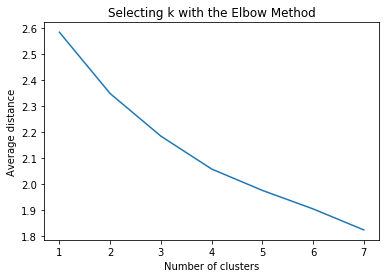

In [146]:
#plot this average distance measure to figure out how many clusters would be optimal 

plt.plot(clusters, meandist)
plt.xlabel('Number of clusters')
plt.ylabel('Average distance')
plt.title('Selecting k with the Elbow Method')

In [147]:
# Interpret 3 cluster solution
model3=KMeans(n_clusters=3)
model3.fit(clus_train)
clusassign=model3.predict(clus_train)

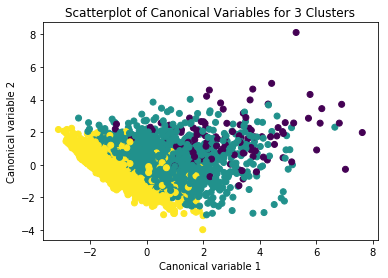

In [148]:
# plot clusters

#We use the canonical discriminant analysis which is a data reduction technique that creates a small number of variables that are Linear combinations of clustering variables

from sklearn.decomposition import PCA
pca_2 = PCA(2)
plot_columns = pca_2.fit_transform(clus_train)
plt.scatter(x=plot_columns[:,0], y=plot_columns[:,1], c=model3.labels_,)
plt.xlabel('Canonical variable 1')
plt.ylabel('Canonical variable 2')
plt.title('Scatterplot of Canonical Variables for 3 Clusters')
plt.show()

In [149]:
# cluster training data to merge with the cluster assignment variable
clus_train.reset_index(level=0, inplace=True)
# create a list that has the new index variable
cluslist=list(clus_train['index'])
# create a list of cluster assignments
labels=list(model3.labels_)
# combine index variable list with cluster assignment list into a dictionary
newlist=dict(zip(cluslist, labels))
newlist
# convert newlist dictionary to a dataframe
newclus=DataFrame.from_dict(newlist, orient='index')
newclus
# rename the cluster assignment column
newclus.columns = ['cluster']

# now do the same for the cluster assignment variable
# create a unique identifier variable from the index for the 
# cluster assignment dataframe 
# to merge with cluster training data
newclus.reset_index(level=0, inplace=True)
# merge the cluster assignment dataframe with the cluster training variable dataframe
# by the index variable
merged_train=pd.merge(clus_train, newclus, on='index')
merged_train.head(n=100)
# cluster frequencies
merged_train.cluster.value_counts()

# calculate clustering variable means by cluster

clustergrp = merged_train.groupby('cluster').mean()
print ('Clustering variable means by cluster')
print(clustergrp)

Clustering variable means by cluster
               index   ALCEVR1  ALCPROBS1   ESTEEM1    EXPEL1   PARPRES  \
cluster                                                                   
0        3391.104839  0.381195   0.713957 -0.173951  4.885093 -0.194714   
1        3311.135625  0.942807   0.298452 -0.089950 -0.204704 -0.089558   
2        3249.769283 -1.056455  -0.412562  0.153246 -0.204704  0.122207   

         SCHCONN1     VIOL1   PARACTV  
cluster                                
0       -0.690922  1.226330 -0.314549  
1       -0.180263  0.090696 -0.020116  
2        0.256807 -0.219775  0.062493  


In [150]:
# validate clusters in training data by examining cluster differences in DEVIANT using ANOVA
#  merge GPA with clustering variables and cluster assignment data

deviant_data=data_clean['DEVIANT1']
# split DEVIANT data into train and test sets

deviant_train, deviant_test = train_test_split(deviant_data, test_size=.3, random_state=123)
deviant_train1=pd.DataFrame(deviant_train)
deviant_train1.reset_index(level=0, inplace=True)
merged_train_all=pd.merge(deviant_train1, merged_train, on='index')
sub1 = merged_train_all[['DEVIANT1', 'cluster']].dropna()

import statsmodels.formula.api as smf
import statsmodels.stats.multicomp as multi

deviantmod = smf.ols(formula='DEVIANT1 ~ C(cluster)', data=sub1).fit()
print (deviantmod.summary())

print ('means for DEVIANT1 by cluster')
m1= sub1.groupby('cluster').mean()
print (m1)

print ('standard deviations for DEVIANT1 by cluster')
m2= sub1.groupby('cluster').std()
print (m2)

mc1 = multi.MultiComparison(sub1['DEVIANT1'], sub1['cluster'])
res1 = mc1.tukeyhsd()
print(res1.summary())




                            OLS Regression Results                            
Dep. Variable:               DEVIANT1   R-squared:                       0.151
Model:                            OLS   Adj. R-squared:                  0.151
Method:                 Least Squares   F-statistic:                     284.8
Date:                Sat, 29 Dec 2018   Prob (F-statistic):          1.47e-114
Time:                        18:37:04   Log-Likelihood:                -8259.3
No. Observations:                3202   AIC:                         1.652e+04
Df Residuals:                    3199   BIC:                         1.654e+04
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
Intercept           6.2742      0.287     

In [152]:
merged_train.cluster.value_counts()

1    1600
2    1478
0     124
Name: cluster, dtype: int64

###  Cluster 0 includes the least adolescents having the least level of deviancy . They had greater self-esteem , school and family connectedness, higher GPA and parents activity and presence.  So cluster 0 include the least troubled adolescents

### Cluster 1 includes the adolescents who had highly used alcohol and marijuana, experienced more alcohol problems, and violent behavior, they appear also to have higher levels of depression, lower self-esteem and school achievement  as well as the lowest levels of school and family connectedness , parents presence and activity.

### Cluster 2 include adolescents who had more used Alcohol but tend to fall in between the two other clusters in the use of Marijuana,  having alcohol problems, engaging in violence, depression, self-esteem, school and family connectedness, parents activity and GPA, with the exception of having higher parental involvement in activities. 


### The first plot shows the decrease of the average distance of the observations from the cluster centroids as the number of clusters increases. The elbow curve suggests that the 2, 3 and 6-cluster solutions might be interpreted. The results below are for an interpretation of the 3-cluster solution.

### A scatterplot (the second plot) of the first two canonical variables by cluster indicated that the observations in clusters in dark green  and purple were densely packed with relatively low within cluster variance, and did not overlap very much with the yellow cluster. Cluster Yellow was generally distinct, and the observations had less spread suggesting low within cluster variance.  The results of this plot suggest that the best cluster solution may have been 2 , so it will be especially important to also evaluate the 2 cluster solution.



